# Observation model

Build an observation model, whereby state space variables predict observed sEEG data.

- [Noise scales](#Noise-scales)
- [Univariate model](#Univariate-model)
- [Multi-node model](#Multi-node-model)

## Noise scales

One of the ongoing difficulties with confronting a model with data, is
the scaling of noise coefficients: if they are too large, the model
or data are meaningless, but if they are too small, the model can't
predict the data (and inference is not possible).

In [157]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from scipy import stats, signal
import lib
lib.cmdstan_path('/Users/maedoc/cmdstan-2.17.0/')

Populating the interactive namespace from numpy and matplotlib


/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'c_']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


'/Users/maedoc/cmdstan-2.17.0/'

## From the raw data

Let's start with raw sEEG data, for completeness:

We load the raw data here, plot it w/ histogram & spectrum.

In [30]:
tf = tarfile.open('trec.tbz')
npy = lib.load_tf_npy(tf, './complex.npy')

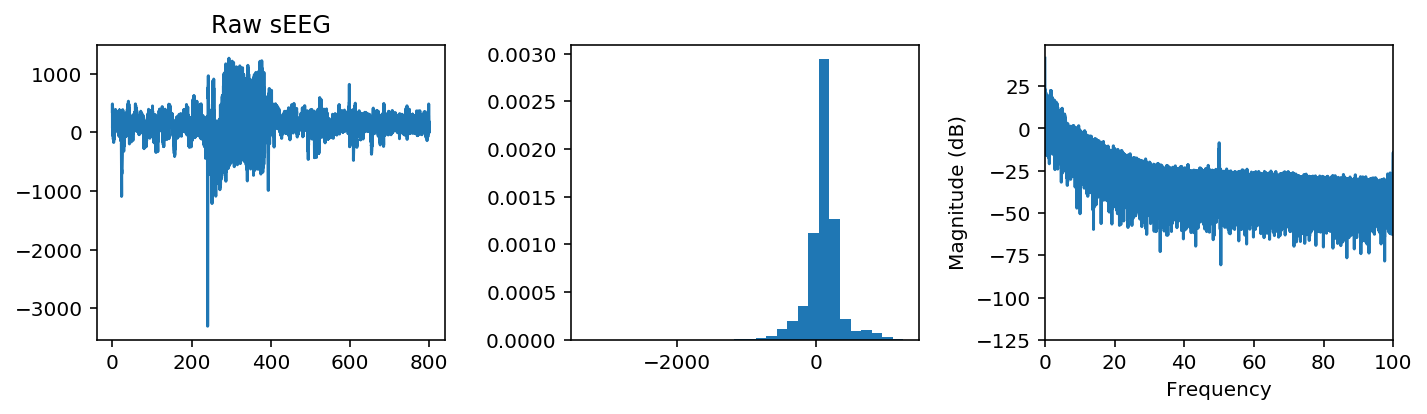

In [118]:
close('all')
k = 5000
nchan, nsamp = npy.shape
t = np.r_[:nsamp] / 512.0
npy = npy[:, t<800]
t = t[t<800]
T = t[:t.size//k*k].reshape((-1, k)).mean(axis=1)
fig, ax = subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].plot(t, npy[0]), ax[0].set_title('Raw sEEG')
ax[1].hist(npy[0], 30, normed=1)
ax[2].magnitude_spectrum(npy[0], Fs=512, scale='dB')
ax[2].set_xlim([0, 100]);
tight_layout()

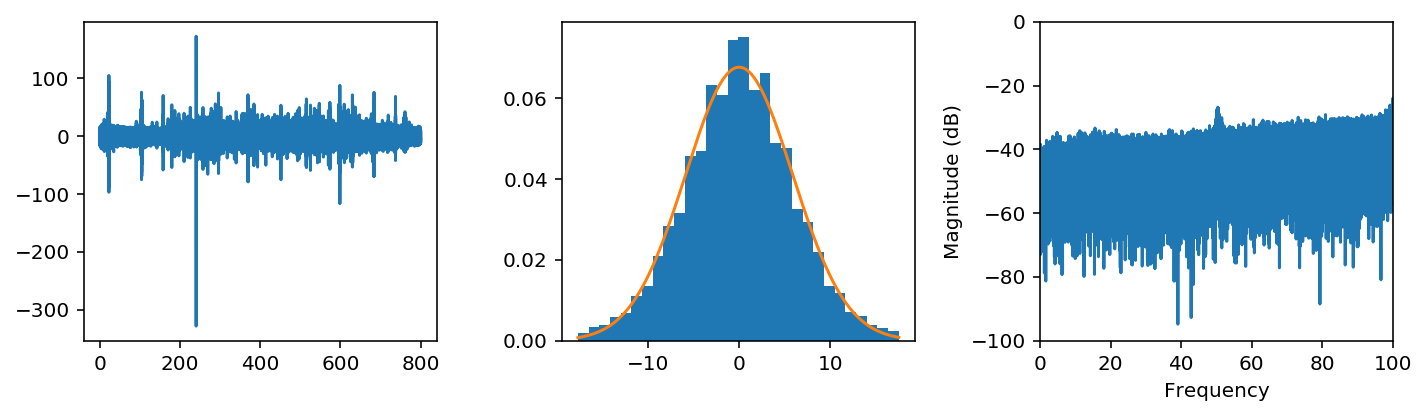

In [120]:
# whiten, roughly normal
fig, ax = subplots(nrows=1, ncols=3, figsize=(10, 3))
c = diff(npy[0], n=2);
c1,c99 = percentile(c, [1, 99])
c_ = c[(c>c1)*(c<c99)]
ax[0].plot(t[:-2], c), ylim([c1,c99])
ax[1].hist(c_, 30, normed=1)
x=r_[c1:c99:500j];
ax[1].plot(x, stats.norm.pdf(x, *stats.norm.fit(c_)));
ax[2].magnitude_spectrum(c_, Fs=512, scale='dB')
ax[2].set_xlim([0, 100]); ax[2].set_ylim([-100, 0])
tight_layout()

As a simple temporal smoothing, we square the above & average windows,

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


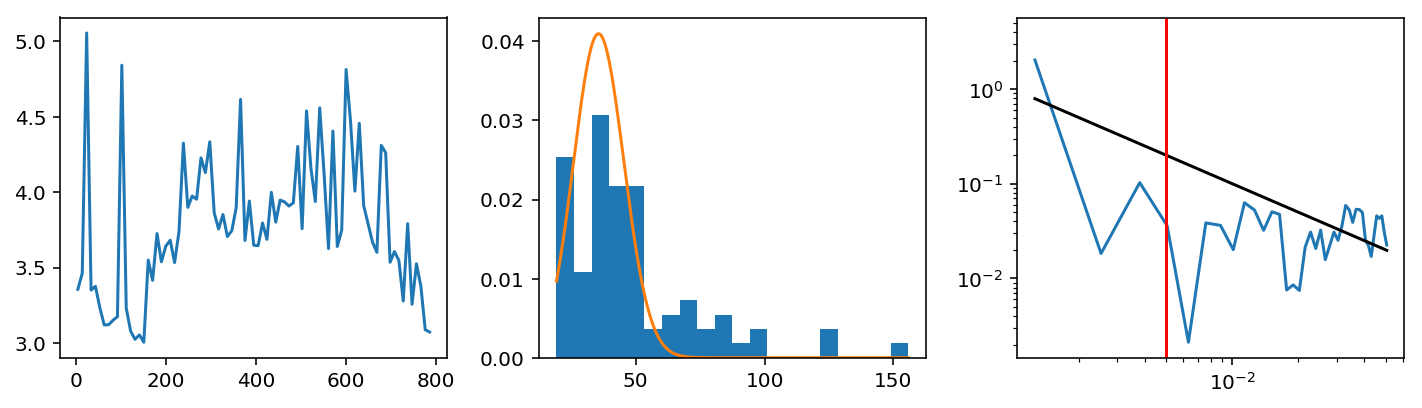

In [121]:
fig, ax = subplots(nrows=1, ncols=3, figsize=(10, 3))
c2 = (c**2)[:c.size//k*k].reshape((-1, k)).mean(axis=1);
ax[1].hist(c2, 20, normed=1); x=r_[c2.min():c2.max():500j]
ax[1].plot(x, stats.chi2.pdf(x, *stats.chi2.fit(c2[c2<percentile(c2,75)], fdf=k)))
ax[0].plot(T[:len(c2)], log(c2+1))
s, f, l = ax[2].magnitude_spectrum(log(c2+1), Fs=512.0/k, scale='dB')
cla()
ax[2].loglog(f, s)
ax[2].loglog(f, 1e-3/f, 'k')
ax[2].axvline(1.0/200, color='r')
tight_layout()

- _Left_ Time-series considered as feature
- _Middle_ Histogram of _Left_ with $\chi_2$ fit
- _Right_ Spectrum of _Left_ with linear approximation in black & seizure cycle frequency marked in <span style="color:red">red</span>.

Let's apply this to all channels to pick favorites

(<matplotlib.image.AxesImage at 0x1226f8d30>,
 <matplotlib.colorbar.Colorbar at 0x2676ef7f0>)

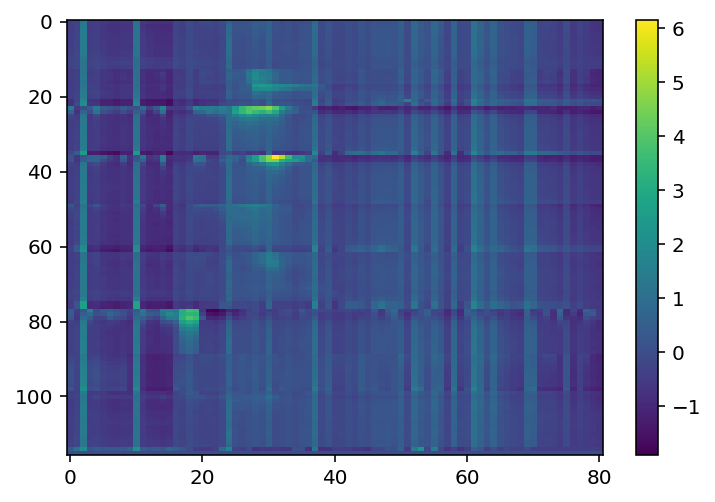

In [122]:
C = np.diff(npy, n=2, axis=1)
C2 = (C**2)[:,:C.shape[1]//k*k].reshape((C.shape[0], -1, k)).mean(axis=2)
lC2 = log(C2 + 1)
lC2 -= lC2.mean(axis=-1)[:, np.newaxis]
imshow(lC2, aspect='auto'), colorbar()

sEEG is recorded in monopolar, but more pertinent information is obtained by bipolar transform.  Here, the data are also further low pass filtered,

In [ ]:
lib.reload()
contacts = lib.contact_names_fd(tf.extractfile('./complex.ades'))
bipnames, bipidx = lib.contacts2bipolar(contacts)

l, r = np.array(bipidx).T
lC2 = log(np.diff(npy[r] - npy[l], n=2, axis=1)**2 + 1)

b, a = signal.butter(3, 2*0.01/512.0, 'low')
# pad a bit for filter
_ = lC2[:,:50000]
lC2 = np.hstack((_, _, lC2))
flC2 = signal.lfilter(b, a, lC2, axis=-1)[:, ::1000]
m = (flC2 > 4).any(axis=1)

In [162]:
cut = flC2[m, 100:400]
for i, _ in enumerate(cut):
    cut[i] = detrend_mean(_)
cut_ = cut.T - cut[:, -0]

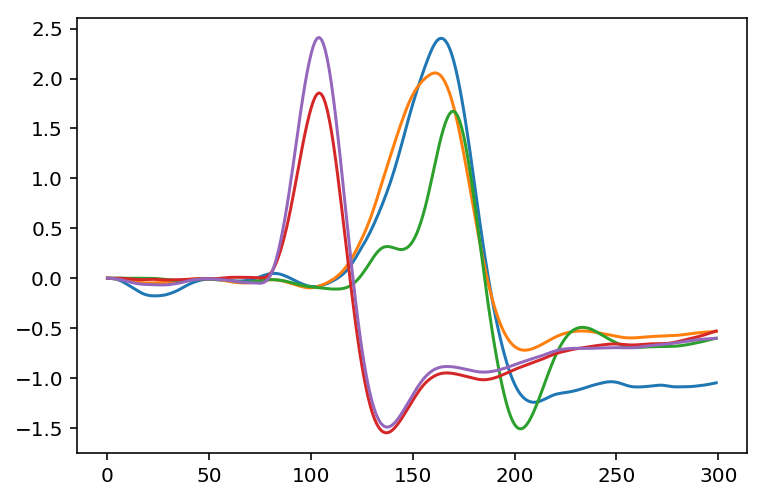

In [163]:
plot(cut_);

That's certain much cleaner, but start & end points aren't same fixed point, and there are still fluctuations that can't be accounted for by ODE, but maybe colored noise.

## Univariate model

We can start with a simple nonlinear dynamical model to reproduce above time series,

--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-obs.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-obs.hpp
Model name=vep_obs_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-obs.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-obs.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /Users/maedoc/Sources/TVB/VEP/vep-obs src/cmdstan/main.cpp -include /Users/maedoc/Sources/TVB/VEP/vep-obs.hpp stan/lib/stan_math/lib/cvodes_2.9.0/lib/libsundials_nvecserial.a stan/lib

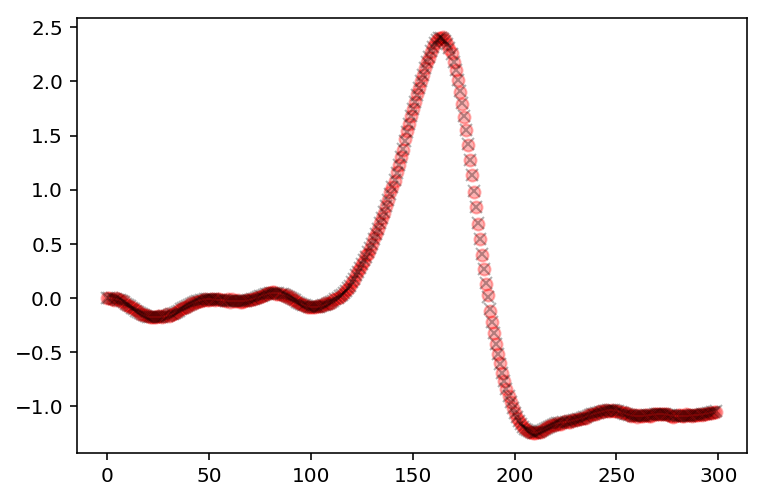

In [372]:
lib.compile_model('vep-obs.stan')

optdata = {
    'nt': cut_.shape[0],
    'y': cut_[:, 0],
    'use_data': 1,
    'dt': 0.01
}
lib.rdump('vep-obs.R', optdata)

!./vep-obs optimize iter=10000 \
    data file=vep-obs.R output file=vep-obs.csv | tail -n2 

csv = lib.parse_csv('vep-obs.csv')
lib.csv2r('vep-obs.csv', 'vep-obs-init.R')
plot(csv['gy'].T, 'ro', alpha=0.3)
plot(cut_[:, 0], 'xk', alpha=0.3)

Looks fine, though we hand picked `dt`. Let's sample

In [373]:
%%bash
./vep-obs sample num_warmup=200 num_samples=200 \
    data file=vep-obs.R \
    output file=vep-obs.sample.csv &> vep-obs.out &

Wait for sampling to finish..

In [387]:
!tail vep-obs.out

Iteration: 100 / 400 [ 25%]  (Warmup)
Iteration: 200 / 400 [ 50%]  (Warmup)
Iteration: 201 / 400 [ 50%]  (Sampling)
Iteration: 300 / 400 [ 75%]  (Sampling)
Iteration: 400 / 400 [100%]  (Sampling)

 Elapsed Time: 12.9076 seconds (Warm-up)
               17.4279 seconds (Sampling)
               30.3355 seconds (Total)



Plot time series with posterior predictive values of signal, as well as hidden state space.

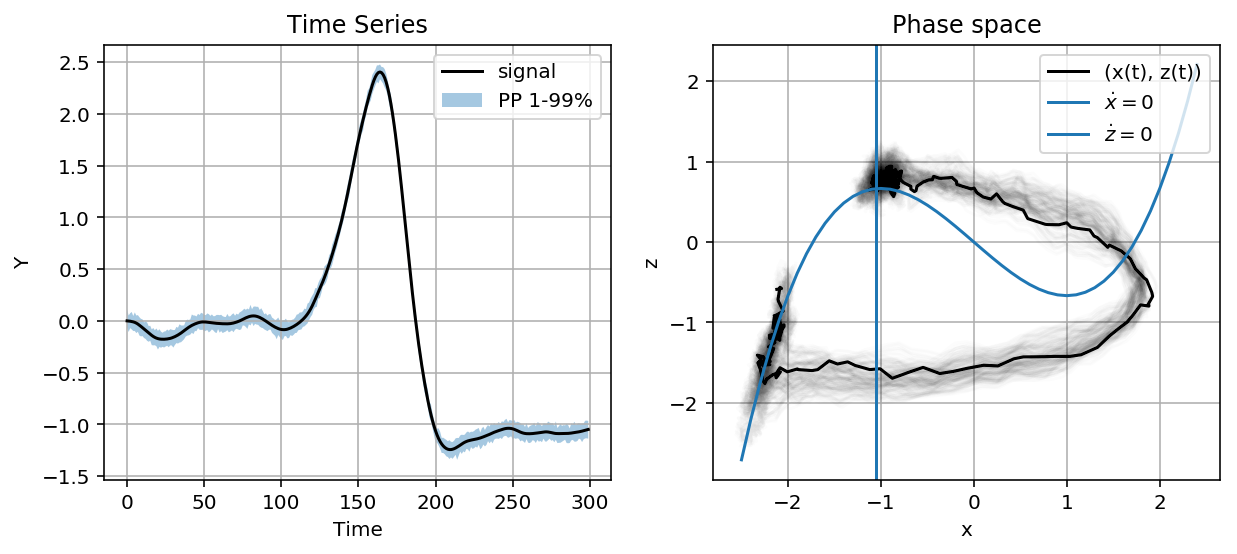

In [388]:
csv = lib.parse_csv('vep-obs.sample.csv')
figure(figsize=(10, 4))
subplot(121)
_ = percentile(csv['gy'], [1, 99], axis=0)
fill_between(r_[:300], _[0], _[1], label='PP 1-99%', alpha=0.4)
plot(cut_[:, 0], 'k', label='signal')
legend(), xlabel('Time'), ylabel('Y'), grid(True), title('Time Series')
subplot(122)
plot(csv['x'][0].T, csv['z'][0].T, 'k', alpha=1, label='(x(t), z(t))');
plot(csv['x'].T, csv['z'].T, 'k', alpha=0.01);
x = r_[-2.5:2.5:0.1]
plot(x, -x + x**3/3, label='$\dot{x}=0$')
axvline(csv['a'].mean(), label='$\dot{z}=0$')
legend(), title('Phase space'), xlabel('x'), ylabel('z'), grid(True);

Though trajectories don't follow the cubic nullcline perfectly, they're still good, and the posterior predictive time series for the signal look OK as well.

Starting from the state-space hypothesis that all nodes sit at a fixed point, prior to seizure onset, we can either normalize by initial values or take initial value to be informative.

## Multi-node model

We can pool estimates of parameters across nodes, where it makes sense, like noise, but for others, it makes sense to allow for variation.

--- Translating Stan model to C++ code ---
bin/stanc  /Users/maedoc/Sources/TVB/VEP/vep-obs-n.stan --o=/Users/maedoc/Sources/TVB/VEP/vep-obs-n.hpp
Model name=vep_obs_n_model
Input file=/Users/maedoc/Sources/TVB/VEP/vep-obs-n.stan
Output file=/Users/maedoc/Sources/TVB/VEP/vep-obs-n.hpp
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

No matches for: 

  real[] * real

Available argument signatures for operator*:

  real * real
  vector * real
  row vector * real
  matrix * real
  row vector * vector
  vector * row vector
  matrix * vector
  row vector * matrix
  matrix * matrix
  real * vector
  real * row vector
  real * matrix

No matches for: 

  real + ill formed

Available argument signatures for operator+:

  int + int
  real + real
  vector + vector
  row vector + row vector
  matrix + matrix
  vector + real
  row vector + real
  matrix + real
  real + vector
  real + row vector
  real + matrix
  +int
  +real
  +vector
  +row vector
  +matrix

expression is ill formed
  error in '/Users/ma

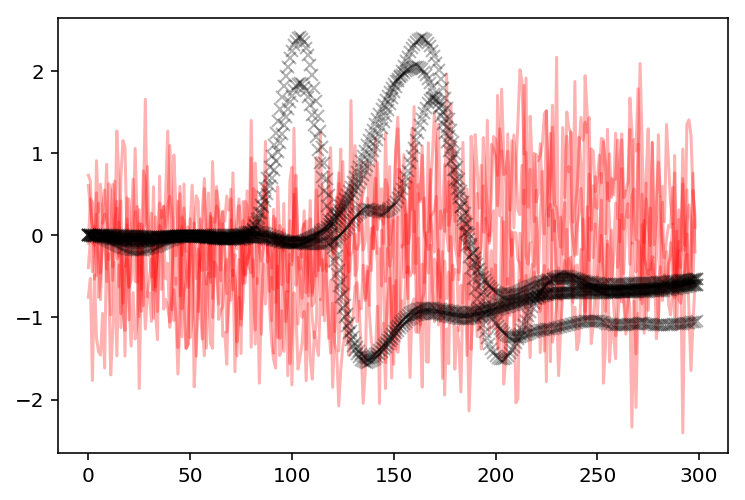

In [371]:
lib.compile_model('vep-obs-n.stan')

lib.rdump('vep-obs-n.R', {
    'nt': cut_.shape[0],
    'nn': cut_.shape[1],
    'y': cut_,
    'use_data': 1
})

!./vep-obs-n optimize iter=10000 \
    data file=vep-obs-n.R \
    output file=vep-obs-n.optimize.csv | tail -n2 

csv = lib.parse_csv('vep-obs-n.optimize.csv')
plot(csv['gy'][0].T, 'r-', alpha=0.3)
plot(cut_, 'xk', alpha=0.3)

In [370]:
csv['a']

array([[ 1.01537 ,  0.745617,  0.680063,  0.888687,  1.00756 ]])